# Sentiment Analysis

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Flatten, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

import time
import itertools
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
df.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [3]:
df.columns = ['sentiment', 'ID', 'date', 'query', 'username', 'tweet']
df.head()

,sentiment,ID,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data = df.drop(['ID', 'date', 'query', 'username'], axis = 1)
sent = { 0: 'Negative', 4: 'Positive'}
def label_decoder(label):
    return sent[label]

data.sentiment = data.sentiment.apply(lambda x : label_decoder(x))
data.head()

,sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

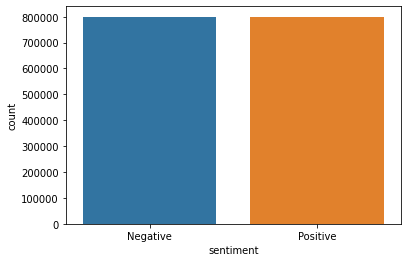

In [5]:
plt.figure()
sns.countplot(data['sentiment'])

In [6]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def preprocess(text, stem = False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens =[]
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

In [7]:
data.tweet[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [8]:
preprocess(data.tweet[0], True)

'awww bummer shoulda got david carr third day'

In [9]:
data.tweet = data.tweet.apply(lambda x : preprocess(x))
data.head()

,sentiment,tweet
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


In [10]:
Train_size = 0.8
max_words = 100000
max_length = 30

In [11]:
train_data, test_data = train_test_split(data, test_size = 1 - Train_size, random_state = 5)
print('size of training data :', len(train_data))
print('size of testing data :',len(test_data))

size of training data : 1280000
size of testing data : 320000


In [12]:
train_data.head()

,sentiment,tweet
887460,Positive,ahaha honestly im even tired suprise woke sooo...
545899,Negative,wtf goldfish hate keep dying poor
835785,Positive,serious finish things
277841,Negative,come think one one tanga ako
1124354,Positive,started following mind direct messaging tell know


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print('VOCAB_SIZE :', vocab_size)

VOCAB_SIZE : 290739


In [14]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet), maxlen = max_length)

print('training x shape :', x_train.shape)
print('testing x shape :', x_test.shape)

training x shape : (1280000, 30)
testing x shape : (320000, 30)


In [15]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.tolist())
y_test = encoder.transform(test_data.sentiment.tolist())

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000,)
y_test shape : (320000,)


In [16]:
y_train = y_train.reshape(1280000,1)
y_test = y_test.reshape(320000,1)

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000, 1)
y_test shape : (320000, 1)


In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-08 17:11:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-08 17:11:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-08 17:11:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
GLOVE_EMB = './glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 12
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [19]:
embeddings_index = {}
file = open(GLOVE_EMB)
for line in file:
    values = line.split()
    word = value = values[0]
    coef = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coef
    
file.close()
print('Found {} word vectors'.format(len(embeddings_index)))

Found 400000 word vectors


In [20]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (290739, 300)


In [21]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                           EMBEDDING_DIM,
                                           weights = [embedding_matrix],
                                           input_length = max_length,
                                           trainable = False)

In [22]:
sequence_input = Input(shape = (max_length), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
# x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

2023-01-08 17:15:17.307591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:15:17.450887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:15:17.452017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:15:17.453973: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           87221700  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [24]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss ='binary_crossentropy',
             metrics = ['accuracy'])

LR_reduction = ReduceLROnPlateau(factor = 0.1,
                                min_lr = 0.0001,
                                monitor = 'val_loss',
                                verbose = 1)

In [25]:
history = model.fit(x_train,
                   y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (x_test, y_test),
                   callbacks = [LR_reduction])

2023-01-08 17:15:21.306130: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 153600000 exceeds 10% of free system memory.
2023-01-08 17:15:21.494417: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2023-01-08 17:15:25.605575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 134s 100ms/step - loss: 0.5197 - accuracy: 0.7390 - val_loss: 0.4819 - val_accuracy: 0.7657
Epoch 2/12
1250/1250 [==============================] - 124s 99ms/step - loss: 0.4865 - accuracy: 0.7630 - val_loss: 0.4721 - val_accuracy: 0.7717
Epoch 3/12
1250/1250 [==============================] - 124s 99ms/step - loss: 0.4762 - accuracy: 0.7699 - val_loss: 0.4669 - val_accuracy: 0.7751
Epoch 4/12
1250/1250 [==============================] - 123s 98ms/step - loss: 0.4704 - accuracy: 0.7733 - val_loss: 0.4653 - val_accuracy: 0.7766
Epoch 5/12
1250/1250 [==============================] - 123s 99ms/step - loss: 0.4660 - accuracy: 0.7765 - val_loss: 0.4621 - val_accuracy: 0.7782
Epoch 6/12
1250/1250 [==============================] - 124s 99ms/step - loss: 0.4625 - accuracy: 0.7784 - val_loss: 0.4630 - val_accuracy: 0.7793
Epoch 7/12
1250/1250 [==============================] - 128s 103ms/step - loss: 0.4598 - accuracy: 0.7802 - val_loss: 0.4603 - v

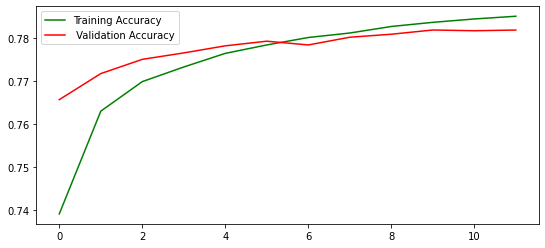

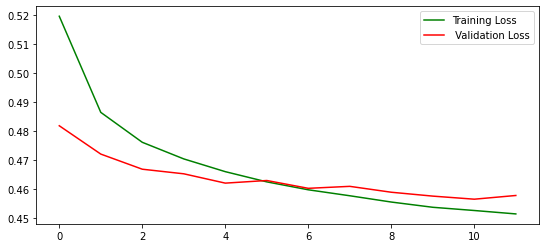

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.figure(figsize = (9,4))
plt.plot(acc, color = 'green', label = 'Training Accuracy')
plt.plot(val_acc, color = 'red', label = ' Validation Accuracy')
plt.legend()

plt.figure(figsize= (9,4))
plt.plot(loss,color = 'green', label = 'Training Loss')
plt.plot(val_loss, color = 'red', label = ' Validation Loss')
plt.legend()

In [27]:
def decode_sentiment(score):
    return 'Positive' if score > 0.5 else 'Negative'

scores = model.predict(x_test, verbose = 1, batch_size = 10000)
y_pred_D = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 2s 39ms/step


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes,rotation = 30)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment= 'center',
             color = "white" if cm[i,j]>thresh else "black")
    
  plt.tight_layout()
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('predicted label')

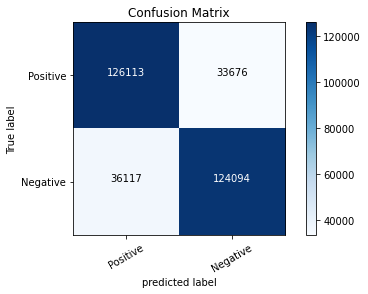

In [29]:
cnf_matrix = confusion_matrix(test_data.sentiment.tolist(), y_pred_D)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = test_data.sentiment.unique(), title = 'confusion matrix')
plt.show()

In [30]:
accuracy = max(acc)
print('Accuracy of model :', accuracy)

Accuracy of model : 0.7851155996322632


In [31]:
print(classification_report(list(test_data.sentiment), y_pred_D))

              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78    159789
    Positive       0.79      0.77      0.78    160211

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [32]:
def final_sentiment(score):
    if (score > 0.6):
        return 'Positive' 
    if (score > 0.4):
        return 'Neutral'
    else:
        return 'Negative'

def pred(text):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length) 
    score = model.predict([x_test])[0]
    label = final_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [33]:
pred("everything is great")

{'label': 'Positive',
 'score': 0.9098560214042664,
 'elapsed_time': 0.40316319465637207}

In [34]:
data = shuffle(data)
searchWords = '|'.join(['sport', 'player', 'game', 'ball'])
filtered = data[data['tweet'].str.contains(searchWords, case=False)]
pd.set_option('display.max_colwidth', 0)
print("Amount of positive tweets:", filtered['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered['sentiment'].value_counts()['Negative'])
filtered.head()

Amount of positive tweets: 10756
Amount of negative tweets: 11506


,sentiment,tweet
987478,Positive,enjoyed games last night cheezen right lakers finals bout time lol
1031979,Positive,remembered class room greetings joymaliksi uhh okay playing games psp momment share
969462,Positive,hell yea watching game
510299,Negative,ahhh confused mp3 player buy
1484694,Positive,exciting fast paced game takes lot accuracy speed skill exciting watch close 2nd rugby


In [35]:
searchWords = '|'.join(['job', 'work', 'weekday', 'commute'])
filtered1 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered1['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered1['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered1.head(10)

Amount of positive tweets: 35628
Amount of negative tweets: 67046


,sentiment,tweet
247111,Negative,trying load new pic amp working
184981,Negative,hate work thing
1237144,Positive,pseudowrimo sounds fun could go finishing story working
498266,Negative,man need start working josey
367483,Negative,today one fucking lame ass shitty day windy weather whack day work ugh
334588,Negative,us met orland brittany birthday go champaign work
447351,Negative,hateee computer want macbook bad geez im desperate turn 16 amp go find job
27865,Negative,beautiful day san diego bad really enjoy working
564131,Negative,getting ready work
1305763,Positive,homework check music never finished reading xxo


In [36]:
searchWords = '|'.join(['Obama', 'Trump', 'politics', 'president', 'election'])
filtered2 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered2['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered2['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered2.head(10)

Amount of positive tweets: 978
Amount of negative tweets: 1209


,sentiment,tweet
1499629,Positive,cuz um wanna clarify know elections today smartass
829293,Positive,kevin ruddy obama following haha fell loved
713356,Negative,video killing iranelection
511646,Negative,want write blog post enormous social impact twitter watching iranelection night busy holiday soon
721619,Negative,dang made lil birthday sex look like ish wit obama visuals black love evrythng lmao
565380,Negative,going see prez obama speak live asu sun devil stadium 7 30 tonight sit 4 hours sun like indian rally
698917,Negative,looks good following iran elections
705622,Negative,voice iran shame country foreign embassies safer hospitals iranelection
630353,Negative,us needs 2 diplomatic since relations w iran always challenging 4 un amnesty int l might care iranelection
535744,Negative,raining chitown listening tai woot home bill beckett obama pizzeria uno


In [37]:
X_data, y_data = np.array(data['tweet']), np.array(data['sentiment'])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)

In [38]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train1))

In [39]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 53200
CPU times: user 2min 28s, sys: 779 ms, total: 2min 29s
Wall time: 1min 21s


In [40]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [41]:
training_model = getModel()
training_model.summary()

NameError: name 'Embedding' is not defined

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = training_model.fit(
    X_train1, y_train1,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)